In [57]:
import pandas as pd
import numpy as np

import sys
import re
import os
project_path = os.getcwd()

# 建模

## 读入数据

In [424]:
df_model =pd.read_excel(project_path +'/data/result/df_model_data_forward.xlsx')
if 'Unnamed: 0' in df_model.columns:
    df_model = df_model.drop(['Unnamed: 0'], axis=1)

In [425]:
df_model.shape

(718, 14)

In [427]:
# discrete_col=['gender','吸烟史','谷胱甘肽','异甘草酸镁','托烷司琼','甘草酸苷','多烯磷脂酰','长春新碱']
discrete_col=['gender','谷胱甘肽','异甘草酸镁','托烷司琼','甘草酸苷','多烯磷脂酰']
continuous_col=[x for x in df_model.columns if x not in discrete_col]
continuous_col.remove('bmd_label')

## 数据归一化

In [428]:
# 防止不同维特征数据差距过大，影响建模效果
for i in continuous_col:
    max_value = df_model[i].max()
    df_model[i]=df_model[i].apply(lambda x: round(x/max_value,3))

In [429]:
df_model.columns

Index(['bmd_label', '单核细胞绝对值', '异甘草酸镁', '甘草酸苷', '托烷司琼', '谷胱甘肽', '嗜酸性细胞百分比',
       '多烯磷脂酰', '嗜碱性细胞百分比', 'gender', 'RBC平均容量', 'MTX_tdm_72h', '白蛋白(干式)',
       'MTX_tdm_48h'],
      dtype='object')

## 插补数据

In [430]:
# 使用随机森林对缺失值进行插补
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
def missing_value_interpolation(df):
    df = df.reset_index(drop=True)
    # 提取存在缺失值的列名
    missing_list = []
    for i in df.columns:
        if df[i].isnull().sum() > 0:
            missing_list.append(i)
    missing_list_copy = missing_list.copy()
    # 用该列未缺失的值训练随机森林，然后用训练好的rf预测缺失值
    for i in range(len(missing_list)):
        name=missing_list[0]
        df_missing = df[missing_list_copy]
        # 将其他列的缺失值用0表示。
        missing_list.remove(name)
        for j in missing_list:
            df_missing[j]=df_missing[j].astype('str').apply(lambda x: 0 if x=='nan' else x)
        df_missing_is = df_missing[df_missing[name].isnull()]
        df_missing_not = df_missing[df_missing[name].notnull()]
        y = df_missing_not[name]
        x = df_missing_not.drop([name],axis=1)
        # 列出参数列表
        tree_grid_parameter = {'n_estimators': list((10, 50, 100, 150, 200))}
        # 进行参数的搜索组合
        grid = GridSearchCV(RandomForestRegressor(),param_grid=tree_grid_parameter,cv=3)
        #rfr=RandomForestRegressor(random_state=0,n_estimators=100,n_jobs=-1)
        #根据已有数据去拟合随机森林模型
        grid.fit(x, y)
        rfr = RandomForestRegressor(n_estimators=grid.best_params_['n_estimators'])
        rfr.fit(x, y)
        #预测缺失值
        predict = rfr.predict(df_missing_is.drop([name],axis=1))
        #填补缺失值
        df.loc[df[name].isnull(),name] = predict
    return df

In [431]:
# 插补建模数据
df_model_cb=missing_value_interpolation(df_model)

In [432]:
# 保存插补数据
writer = pd.ExcelWriter(project_path + '/data/result/df_model_data_插补.xlsx')
df_model_cb.to_excel(writer)
writer.save()

## 相关性检测

In [42]:
#  连续变量，spearmanr相关性检验(统计量r);
print('--------------------------计算连续变量的spearmanr相关性系数---------------------------------')
from scipy import stats
t_list = []
p_list = []
q_list = []

for i in continuous_col:
    # 删除连续变量中的<、>号
    df_model_cb[i] = df_model_cb[i].astype('str').apply(lambda x: re.sub(r'<|>', '',x))
    x= df_model_cb[df_model_cb[i].astype('float').notnull()][i]
    y= df_model_cb[df_model_cb[i].astype('float').notnull()]['bmd_label']
    t, p = stats.spearmanr(x,y)
    t = round(t, 2)
    p = round(p, 3)
    q = '斯皮尔曼'
    # print(i, t, p)

    t_list.append(t)
    p_list.append(p)
    q_list.append(q)
df_spearmanr= pd.DataFrame(data={'连续检测指标': continuous_col,
                                't值': t_list,
                                'p值': p_list,
                                '方法': q_list})
df_spearmanr_1 = df_spearmanr[df_spearmanr['p值'] <= 0.05]
df_spearmanr_2 = df_spearmanr[df_spearmanr['p值'] >= 0.05]  # 显著性不成立
df_spearmanr = pd.concat([df_spearmanr_1,df_spearmanr_2], axis=0)

df_spearmanr=df_spearmanr.sort_values(by=['p值'],ascending=False)
df_spearmanr = df_spearmanr.reset_index(drop=True)

writer = pd.ExcelWriter(project_path + '/data/result/df_temp_spearmanr相关性检测.xlsx')
df_spearmanr.to_excel(writer)
writer.save()

--------------------------计算连续变量的spearmanr相关性系数---------------------------------


## 划分数据集

In [433]:
from auto_ml.utils_models import load_ml_model
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [1128]:
from auto_ml import Predictor
# 划分训练集和测试集，比例为8:2
x = df_model_cb.drop(['bmd_label'],axis=1)
y = df_model_cb['bmd_label']

tran_x, test_x, tran_y, test_y = train_test_split(x, y, test_size=0.2, random_state=5)


In [1129]:
tran_x.shape

(574, 13)

## 训练集过采样

In [1130]:
# 进行过采样
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=0)

tran_x_sm,tran_y_sm = sm.fit_resample(tran_x,tran_y)

In [1131]:
tran_x_sm.shape

(1070, 13)

In [1132]:
tran_x_sm

,单核细胞绝对值,异甘草酸镁,甘草酸苷,托烷司琼,谷胱甘肽,嗜酸性细胞百分比,多烯磷脂酰,嗜碱性细胞百分比,gender,RBC平均容量,MTX_tdm_72h,白蛋白(干式),MTX_tdm_48h
0,0.150000,0,0,0,0,0.017000,0,0.115000,0,0.759000,0.002000,0.640000,0.002000
1,0.150000,1,0,1,0,0.108000,0,0.115000,1,0.837000,0.002000,0.720000,0.033000
2,0.050000,0,0,1,1,0.034000,0,0.231000,1,0.783000,0.002000,0.760000,0.002000
3,0.050000,0,0,1,0,0.028000,0,0.077000,1,0.797000,0.003000,0.660000,0.051000
4,0.050000,1,0,1,1,0.102000,1,0.462000,1,0.845000,0.002000,0.700000,0.002000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065,0.235257,0,0,0,0,0.058676,0,0.072203,1,0.814871,0.002705,0.731794,0.043604
1066,0.850984,0,0,0,0,0.000000,0,0.115000,0,0.779832,0.003192,0.759606,0.007365
1067,0.500000,0,0,0,0,0.002777,0,0.079367,0,0.798041,0.014901,0.677021,0.034234
1068,0.100000,0,0,0,0,0.079053,0,0.216608,0,0.840321,0.002080,0.748884,0.016544


## 训练模型

In [1179]:
from sklearn.metrics import r2_score,average_precision_score,precision_recall_curve
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score,accuracy_score


import xgboost
feature_list=[]
model_name=[]
precision_list=[]
recall_list=[]
f1_list=[]
auc_list=[]
accuracy_list=[]
# XGBoost模型

xgb_model=xgboost.XGBClassifier(max_depth=5,
                        learning_rate=0.01,
                        n_estimators=500,
                        min_child_weight=0.5,
                        eta=0.1,
                        gamma=0.5,
                        reg_lambda=10,
                        subsample=0.5,
                        colsample_bytree=0.8,
                        nthread=4,
                        scale_pos_weight=1,
                        random_state=3)
xgb_model.fit(tran_x_sm,tran_y_sm)
xgb_predictions=xgb_model.predict(test_x)

xgb_precision = precision_score(test_y,xgb_predictions)
xgb_recall=recall_score(test_y,xgb_predictions)
xgb_f1=f1_score(test_y,xgb_predictions)
xgb_auc=roc_auc_score(test_y,xgb_predictions)
xgb_accuracy=accuracy_score(test_y,xgb_predictions)
print('xgb',xgb_precision,xgb_recall,xgb_f1,xgb_auc,xgb_accuracy)

feature_list.append(feature_list)
model_name.append('xgb')
precision_list.append(round(xgb_precision,3))
recall_list.append(round(xgb_recall,3))
f1_list.append(round(xgb_f1,3))
auc_list.append(round(xgb_auc,3))
accuracy_list.append(round(xgb_accuracy,3))

import lightgbm
# LightGBM模型
lgbm_model=lightgbm.LGBMClassifier(iterations=300, 
                                  max_depth=5,
                                  min_child_weight=0.5,
                                  gamma=0.5,
                                  subsample=0.5,
                                  learning_rate=0.01, 
                                  loss_function='CrossEntropy',
                                  random_state=3)
lgbm_model.fit(tran_x_sm,tran_y_sm)
lgbm_predictions=lgbm_model.predict(test_x)

lgbm_precision = precision_score(test_y,lgbm_predictions)
lgbm_recall=recall_score(test_y,lgbm_predictions)
lgbm_f1=f1_score(test_y,lgbm_predictions)
lgbm_auc=roc_auc_score(test_y,lgbm_predictions)
lgbm_accuracy=accuracy_score(test_y,lgbm_predictions)
print('lgbm',lgbm_precision,lgbm_recall,lgbm_f1,lgbm_auc,lgbm_accuracy)

feature_list.append(feature_list)
model_name.append('LGBM')
precision_list.append(round(lgbm_precision,3))
recall_list.append(round(lgbm_recall,3))
f1_list.append(round(lgbm_f1,3))
auc_list.append(round(lgbm_auc,3))
accuracy_list.append(round(lgbm_accuracy,3))

import catboost
# CatBoost模型
cat_model=catboost.CatBoostClassifier(iterations=300, 
                                      learning_rate=0.01, 
                                      depth=6,
                                      l2_leaf_reg=2,
                                      subsample=0.5,
                                      loss_function='Logloss',
                                      random_state=3)
cat_model.fit(tran_x_sm,tran_y_sm)
cat_predictions=cat_model.predict(test_x)

cat_precision = precision_score(test_y,cat_predictions)
cat_recall=recall_score(test_y,cat_predictions)
cat_f1=f1_score(test_y,cat_predictions)
cat_auc=roc_auc_score(test_y,cat_predictions)
cat_accuracy=accuracy_score(test_y,cat_predictions)
print('catboost',cat_precision,cat_recall,cat_f1,cat_auc,cat_accuracy)

feature_list.append(feature_list)
model_name.append('catboost')
precision_list.append(round(cat_precision,3))
recall_list.append(round(cat_recall,3))
f1_list.append(round(cat_f1,3))
auc_list.append(round(cat_auc,3))
accuracy_list.append(round(cat_accuracy,3))


# 随机森林
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
# 列出参数列表
tree_grid_parameter = {'n_estimators': list((10, 50, 100, 150, 200))}
# 进行参数的搜索组合
grid = GridSearchCV(RandomForestClassifier(), param_grid=tree_grid_parameter, cv=3)
# 根据已有数据去拟合随机森林模型
grid.fit(tran_x_sm, tran_y_sm)
rfr = RandomForestClassifier(n_estimators=grid.best_params_['n_estimators'],random_state=3)
rfr.fit(tran_x_sm, tran_y_sm)
# 预测缺失值
rf_predictions = rfr.predict(test_x)

rf_precision = precision_score(test_y,rf_predictions)
rf_recall=recall_score(test_y,rf_predictions)
rf_f1=f1_score(test_y,rf_predictions)
rf_auc=roc_auc_score(test_y,rf_predictions)
rf_accuracy=accuracy_score(test_y,rf_predictions)
print('rf',rf_precision,rf_recall,rf_f1,rf_auc,rf_accuracy)

feature_list.append(feature_list)
model_name.append('RF')
precision_list.append(round(rf_precision,3))
recall_list.append(round(rf_recall,3))
f1_list.append(round(rf_f1,3))
auc_list.append(round(rf_auc,3))
accuracy_list.append(round(rf_accuracy,3))


# GBDT
# 列出参数列表
gbdt_model = GradientBoostingClassifier(n_estimators=300,
                            learning_rate=0.01,
                            max_depth=5,
                            subsample=0.5)
gbdt_model.fit(tran_x_sm,tran_y_sm)
# 预测缺失值
gbdt_predictions = gbdt_model.predict(test_x)
gbdt_precision = precision_score(test_y,gbdt_predictions)
gbdt_recall=recall_score(test_y,gbdt_predictions)
gbdt_f1=f1_score(test_y,gbdt_predictions)
gbdt_auc=roc_auc_score(test_y,gbdt_predictions)
gbdt_accuracy=accuracy_score(test_y,gbdt_predictions)
print('gbdt',gbdt_precision,gbdt_recall,gbdt_f1,gbdt_auc,gbdt_accuracy)

feature_list.append(feature_list)
model_name.append('GBDT')
precision_list.append(round(gbdt_precision,3))
recall_list.append(round(gbdt_recall,3))
f1_list.append(round(gbdt_f1,3))
auc_list.append(round(gbdt_auc,3))
accuracy_list.append(round(gbdt_accuracy,3))


# SVR
from sklearn.svm import SVR,SVC
# 回归模型
# svr = SVR(kernel='linear', C=1.25)
# 分类模型
svr = SVC(kernel='linear',
          C=1.25,
          cache_size=200,
          random_state=3)
svr.fit(tran_x_sm,tran_y_sm)
svr_predictions=svr.predict(test_x)

svr_precision = precision_score(test_y,svr_predictions)
svr_recall=recall_score(test_y,svr_predictions)
svr_f1=f1_score(test_y,svr_predictions)
svr_auc=roc_auc_score(test_y,svr_predictions)
svr_accuracy=accuracy_score(test_y,svr_predictions)
print('SVC',svr_precision,svr_recall,svr_f1,svr_auc,svr_accuracy)

feature_list.append(feature_list)
model_name.append('SVC')
precision_list.append(round(svr_precision,3))
recall_list.append(round(svr_recall,3))
f1_list.append(round(svr_f1,3))
auc_list.append(round(svr_auc,3))
accuracy_list.append(round(svr_accuracy,3))


# Linear回归，Lasso回归，领回归，logistic回归
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet,LogisticRegression
lcv = LogisticRegression(penalty='l2',
                         C=1.25,
                        solver='lbfgs',
                         max_iter=100,
                        random_state=3)
# lcv = Lasso()
# lcv = Ridge()
lcv.fit(tran_x_sm, tran_y_sm)
lcv_predictions = lcv.predict(test_x)

lcv_precision = precision_score(test_y,lcv_predictions)
lcv_recall=recall_score(test_y,lcv_predictions)
lcv_f1=f1_score(test_y,lcv_predictions)
lcv_auc=roc_auc_score(test_y,lcv_predictions)
lcv_accuracy=accuracy_score(test_y,lcv_predictions)
print('lr',lcv_precision,lcv_recall,lcv_f1,lcv_auc,lcv_accuracy)

feature_list.append(feature_list)
model_name.append('lr')
precision_list.append(round(lcv_precision,3))
recall_list.append(round(lcv_recall,3))
f1_list.append(round(lcv_f1,3))
auc_list.append(round(lcv_auc,3))
accuracy_list.append(round(lcv_accuracy,3))


# ANN
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix

ANN = MLPClassifier(alpha=0.01, 
                    hidden_layer_sizes=[50,], 
                    solver='adam', 
                    activation='relu', 
                    random_state=3)
ANN.fit(tran_x_sm, tran_y_sm)
ann_predictions=ANN.predict(test_x)

ann_precision = precision_score(test_y,ann_predictions)
ann_recall=recall_score(test_y,ann_predictions)
ann_f1=f1_score(test_y,ann_predictions)
ann_auc=roc_auc_score(test_y,ann_predictions)
ann_accuracy=accuracy_score(test_y,ann_predictions)
print('ann',ann_precision,ann_recall,ann_f1,ann_auc,ann_accuracy)

feature_list.append(feature_list)
model_name.append('ann')
precision_list.append(round(ann_precision,3))
recall_list.append(round(ann_recall,3))
f1_list.append(round(ann_f1,3))
auc_list.append(round(ann_auc,3))
accuracy_list.append(round(ann_accuracy,3))


# TabNet
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
TabNet_model = TabNetClassifier(n_d=8, 
                               n_a=8,
                               n_steps=3, # Number of steps in the architecture (usually between 3 and 10)
                               gamma=1.3,
                               n_independent=2)  #TabNetRegressor()
tran_x_x, tran_x_valid, tran_y_y, tran_y_valid = train_test_split(tran_x_sm, tran_y_sm, test_size=0.125, random_state=3)

TabNet_model.fit(X_train=tran_x_x.to_numpy(), 
        y_train=tran_y_y.to_numpy(), 
        eval_set=[(tran_x_valid.to_numpy(), tran_y_valid.to_numpy())], 
        eval_name=['train'], 
        eval_metric=['auc'],
        max_epochs=100,
        patience=15,
        batch_size=128,
        virtual_batch_size=16,
        num_workers=0,
        drop_last=False)

tab_predictions=TabNet_model.predict(test_x.to_numpy())

tab_precision = precision_score(test_y,tab_predictions)
tab_recall=recall_score(test_y,tab_predictions)
tab_f1=f1_score(test_y,tab_predictions)
tab_auc=roc_auc_score(test_y,tab_predictions)
tab_accuracy=accuracy_score(test_y,tab_predictions)
print('tab',tab_precision,tab_recall,tab_f1,tab_auc,tab_accuracy)

feature_list.append(feature_list)
model_name.append('TabNet')
precision_list.append(round(tab_precision,3))
recall_list.append(round(tab_recall,3))
f1_list.append(round(tab_f1,3))
auc_list.append(round(tab_auc,3))
accuracy_list.append(round(tab_accuracy,3))

xgb 0.8 0.8571428571428571 0.8275862068965518 0.917032967032967 0.9652777777777778
lgbm 0.5652173913043478 0.9285714285714286 0.7027027027027025 0.9258241758241759 0.9236111111111112
0:	learn: 0.5503771	total: 1.74ms	remaining: 522ms
1:	learn: 0.4427124	total: 3.75ms	remaining: 558ms
2:	learn: 0.3692611	total: 5.22ms	remaining: 517ms
3:	learn: 0.3166312	total: 6.68ms	remaining: 494ms
4:	learn: 0.2759761	total: 8.79ms	remaining: 519ms
5:	learn: 0.2463780	total: 10.3ms	remaining: 507ms
6:	learn: 0.2205790	total: 12ms	remaining: 500ms
7:	learn: 0.2001801	total: 13.7ms	remaining: 501ms
8:	learn: 0.1864072	total: 15.3ms	remaining: 494ms
9:	learn: 0.1738955	total: 16.8ms	remaining: 487ms
10:	learn: 0.1652035	total: 18.8ms	remaining: 494ms
11:	learn: 0.1534695	total: 20.7ms	remaining: 496ms
12:	learn: 0.1451246	total: 22.5ms	remaining: 497ms
13:	learn: 0.1390237	total: 24ms	remaining: 490ms
14:	learn: 0.1339576	total: 25.8ms	remaining: 490ms
15:	learn: 0.1283510	total: 27.2ms	remaining: 483ms

183:	learn: 0.0075970	total: 268ms	remaining: 169ms
184:	learn: 0.0075435	total: 270ms	remaining: 168ms
185:	learn: 0.0075435	total: 271ms	remaining: 166ms
186:	learn: 0.0075091	total: 273ms	remaining: 165ms
187:	learn: 0.0074348	total: 274ms	remaining: 163ms
188:	learn: 0.0073570	total: 276ms	remaining: 162ms
189:	learn: 0.0072639	total: 277ms	remaining: 160ms
190:	learn: 0.0072546	total: 278ms	remaining: 159ms
191:	learn: 0.0071955	total: 280ms	remaining: 158ms
192:	learn: 0.0071275	total: 282ms	remaining: 156ms
193:	learn: 0.0070711	total: 283ms	remaining: 155ms
194:	learn: 0.0070048	total: 285ms	remaining: 153ms
195:	learn: 0.0069556	total: 286ms	remaining: 152ms
196:	learn: 0.0068970	total: 288ms	remaining: 150ms
197:	learn: 0.0068614	total: 289ms	remaining: 149ms
198:	learn: 0.0068241	total: 291ms	remaining: 147ms
199:	learn: 0.0067651	total: 292ms	remaining: 146ms
200:	learn: 0.0066873	total: 294ms	remaining: 145ms
201:	learn: 0.0066255	total: 295ms	remaining: 143ms
202:	learn: 

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


ann 0.7058823529411765 0.8571428571428571 0.7741935483870968 0.9093406593406594 0.9513888888888888
Device used : cpu
epoch 0  | loss: 0.81276 | train_auc: 0.82888 |  0:00:00s
epoch 1  | loss: 0.55581 | train_auc: 0.791   |  0:00:00s
epoch 2  | loss: 0.44858 | train_auc: 0.83266 |  0:00:00s
epoch 3  | loss: 0.39995 | train_auc: 0.8672  |  0:00:00s
epoch 4  | loss: 0.39006 | train_auc: 0.89884 |  0:00:01s
epoch 5  | loss: 0.38219 | train_auc: 0.92758 |  0:00:01s
epoch 6  | loss: 0.34743 | train_auc: 0.93694 |  0:00:01s
epoch 7  | loss: 0.28715 | train_auc: 0.94051 |  0:00:01s
epoch 8  | loss: 0.25957 | train_auc: 0.9443  |  0:00:02s
epoch 9  | loss: 0.27611 | train_auc: 0.95967 |  0:00:02s
epoch 10 | loss: 0.27404 | train_auc: 0.96234 |  0:00:02s
epoch 11 | loss: 0.24259 | train_auc: 0.97193 |  0:00:02s
epoch 12 | loss: 0.25013 | train_auc: 0.97237 |  0:00:03s
epoch 13 | loss: 0.23695 | train_auc: 0.9668  |  0:00:03s
epoch 14 | loss: 0.24587 | train_auc: 0.96858 |  0:00:03s
epoch 15 | lo

In [1180]:
df_model_result=pd.DataFrame(data={'model':model_name,
                                  'precision':precision_list,
                                  'recall':recall_list,
                                  'f1':f1_list,
                                  'auc':auc_list,
                                  'accuracy':accuracy_list})

In [1181]:
df_model_result

,model,precision,recall,f1,auc,accuracy
0,xgb,0.800,0.857,0.828,0.917,0.965
1,LGBM,0.565,0.929,0.703,0.926,0.924
2,catboost,0.846,0.786,0.815,0.885,0.965
3,RF,0.833,0.714,0.769,0.849,0.958
4,GBDT,0.833,0.714,0.769,0.849,0.958
5,SVC,0.722,0.929,0.813,0.945,0.958
6,lr,0.722,0.929,0.813,0.945,0.958
7,ann,0.706,0.857,0.774,0.909,0.951
8,TabNet,0.812,0.929,0.867,0.953,0.972


In [1184]:
# 保存模型测试效果
df_model_result.to_excel(project_path+'/data/result/df_模型测试效果.xlsx')

### xgboost

In [1054]:
# 直接使用xgboost和catboost包，而不是auto_ml
import xgboost
import lightgbm
import catboost
from sklearn.metrics import r2_score,precision_score,recall_score,f1_score,roc_auc_score,accuracy_score
from sklearn.metrics import classification_report,confusion_matrix,average_precision_score,precision_recall_curve

xgb_model=xgboost.XGBClassifier(max_depth=5,
                        learning_rate=0.01,
                        n_estimators=500,
                        min_child_weight=0.5,
                        eta=0.1,
                        gamma=0.5,
                        reg_lambda=5,
                        subsample=0.5,
                        colsample_bytree=0.8,
                        nthread=4,
                        scale_pos_weight=1,
                        random_state=3)

xgb_model.fit(tran_x_sm,tran_y_sm)
xgb_predictions=xgb_model.predict(test_x)

xgb_precision = precision_score(test_y,xgb_predictions)
xgb_recall=recall_score(test_y,xgb_predictions)
xgb_f1=f1_score(test_y,xgb_predictions)
xgb_auc=roc_auc_score(test_y,xgb_predictions)
xgb_accuracy=accuracy_score(test_y,xgb_predictions)
print(xgb_precision,xgb_recall,xgb_f1,xgb_auc,xgb_accuracy)

# xgb_fpr, xgb_tpr, thresholds = metrics.roc_curve(test_y, predictions, pos_label=1)  #pos_label=2，表示值为2的实际值为正样本
# xgb_auc=roc_auc_score(test_y,predictions)

# xgb_ap = average_precision_score(test_y, predictions)
# xgb_precision, xgb_recall, _ = precision_recall_curve(test_y, predictions)
# # print(predictions)
# print(classification_report(test_y, xgb_model.predict(test_x)))
# cm2_LogR_model = confusion_matrix(test_y, xgb_model.predict(test_x))
# print(cm2_LogR_model) #混肴矩阵

0.8 0.8571428571428571 0.8275862068965518 0.917032967032967 0.9652777777777778


In [1055]:
predictions

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

### LGBM

In [261]:
import lightgbm
# LightGBM模型
xgb_model=lightgbm.LGBMClassifier(iterations=300, 
                                  max_depth=5,
                                  min_child_weight=0.5,
                                  gamma=0.5,
                                  subsample=0.7,
                                  learning_rate=0.01, 
                                  loss_function='CrossEntropy',
                                  random_state=3)
xgb_model.fit(tran_x_sm,tran_y_sm)
predictions=xgb_model.predict(test_x)

precision = precision_score(test_y,predictions)
recall=recall_score(test_y,predictions)
f1=f1_score(test_y,predictions)
auc=roc_auc_score(test_y,predictions)
accuracy=accuracy_score(test_y,predictions)
print('lgbm',precision,recall,f1)

lgbm 0.65 0.9285714285714286 0.7647058823529412


### CatBoost

In [775]:
?catboost.CatBoostClassifier

In [1182]:
import catboost
# CatBoost模型
xgb_model=catboost.CatBoostClassifier(iterations=300, 
                                      learning_rate=0.01, 
                                      depth=6,
                                      l2_leaf_reg=2,
                                      subsample=0.5,
                                      loss_function='CrossEntropy',
                                      random_state=3)
xgb_model.fit(tran_x_sm,tran_y_sm)
predictions=xgb_model.predict(test_x)

precision = precision_score(test_y,predictions)
recall=recall_score(test_y,predictions)
f1=f1_score(test_y,predictions)
auc=roc_auc_score(test_y,predictions)
accuracy=accuracy_score(test_y,predictions)
print('catboost',precision,recall,f1,auc,accuracy)

0:	learn: 0.6773717	total: 1.61ms	remaining: 481ms
1:	learn: 0.6616230	total: 3.23ms	remaining: 481ms
2:	learn: 0.6472896	total: 4.73ms	remaining: 468ms
3:	learn: 0.6351849	total: 6.19ms	remaining: 458ms
4:	learn: 0.6221843	total: 7.77ms	remaining: 458ms
5:	learn: 0.6107424	total: 10.2ms	remaining: 498ms
6:	learn: 0.5972125	total: 11.7ms	remaining: 491ms
7:	learn: 0.5853148	total: 13.4ms	remaining: 487ms
8:	learn: 0.5725275	total: 14.9ms	remaining: 482ms
9:	learn: 0.5613435	total: 16.4ms	remaining: 477ms
10:	learn: 0.5506939	total: 18ms	remaining: 474ms
11:	learn: 0.5398735	total: 19.6ms	remaining: 471ms
12:	learn: 0.5285518	total: 21.2ms	remaining: 467ms
13:	learn: 0.5172157	total: 22.7ms	remaining: 464ms
14:	learn: 0.5076527	total: 24.2ms	remaining: 459ms
15:	learn: 0.4986373	total: 25.6ms	remaining: 454ms
16:	learn: 0.4882007	total: 27.4ms	remaining: 456ms
17:	learn: 0.4808996	total: 28.6ms	remaining: 449ms
18:	learn: 0.4715817	total: 30.1ms	remaining: 445ms
19:	learn: 0.4622966	tot

219:	learn: 0.1026505	total: 323ms	remaining: 117ms
220:	learn: 0.1025366	total: 324ms	remaining: 116ms
221:	learn: 0.1023105	total: 325ms	remaining: 114ms
222:	learn: 0.1021079	total: 327ms	remaining: 113ms
223:	learn: 0.1017309	total: 329ms	remaining: 112ms
224:	learn: 0.1015683	total: 331ms	remaining: 110ms
225:	learn: 0.1011676	total: 332ms	remaining: 109ms
226:	learn: 0.1008553	total: 334ms	remaining: 107ms
227:	learn: 0.1004453	total: 335ms	remaining: 106ms
228:	learn: 0.1000578	total: 337ms	remaining: 104ms
229:	learn: 0.0998915	total: 338ms	remaining: 103ms
230:	learn: 0.0995549	total: 340ms	remaining: 101ms
231:	learn: 0.0993045	total: 342ms	remaining: 100ms
232:	learn: 0.0991244	total: 344ms	remaining: 98.8ms
233:	learn: 0.0989042	total: 345ms	remaining: 97.3ms
234:	learn: 0.0986183	total: 347ms	remaining: 95.9ms
235:	learn: 0.0984781	total: 349ms	remaining: 94.6ms
236:	learn: 0.0980622	total: 350ms	remaining: 93.1ms
237:	learn: 0.0977434	total: 352ms	remaining: 91.6ms
238:	l

In [1183]:
print('catboost',precision,recall,f1,auc,accuracy)

catboost 0.8125 0.9285714285714286 0.8666666666666666 0.9527472527472527 0.9722222222222222


### Random Forest

In [226]:
?RandomForestClassifier()

Object `RandomForestClassifier()` not found.


In [353]:
# 随机森林，GBDT
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
# 列出参数列表
tree_grid_parameter = {'n_estimators': list((10, 50, 100, 150, 200))}
# 进行参数的搜索组合
grid = GridSearchCV(RandomForestClassifier(), param_grid=tree_grid_parameter, cv=3)
# 根据已有数据去拟合随机森林模型
grid.fit(tran_x_sm, tran_y_sm)
rfr = RandomForestClassifier(n_estimators=grid.best_params_['n_estimators'],
                            max_depth=5,
                            random_state=3)
rfr.fit(tran_x_sm, tran_y_sm)
# 预测缺失值
predictions = rfr.predict(test_x)

precision = precision_score(test_y,predictions)
recall=recall_score(test_y,predictions)
f1=f1_score(test_y,predictions)
print('tab',precision,recall,f1)

tab 0.7857142857142857 0.7857142857142857 0.7857142857142857


### GBDT

In [225]:
# GBDT
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
# 列出参数列表
tree_grid_parameter = {'n_estimators': [200,300,500],
                      'learning_rate': [0.01,0.1],
                      'max_depth': [3,5],
                      'subsample':[0.5,0.6,0.8]}
# 进行参数的搜索组合
grid = GridSearchCV(GradientBoostingClassifier(), param_grid=tree_grid_parameter, cv=3)
# 根据已有数据去拟合随机森林模型
grid.fit(tran_x_sm, tran_y_sm)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5],
                         'n_estimators': [200, 300, 500],
                         'subsample': [0.5, 0.6, 0.8]})

In [227]:
grid.best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}

In [228]:
grid.best_params_['n_estimators']

300

In [1145]:
rfr = GradientBoostingClassifier(n_estimators=300,
                            learning_rate=0.01,
                            max_depth=5,
                            subsample=0.5)
rfr.fit(tran_x_sm, tran_y_sm)
# 预测缺失值
predictions = rfr.predict(test_x)
precision = precision_score(test_y,predictions)
recall=recall_score(test_y,predictions)
f1=f1_score(test_y,predictions)
print('rf',precision,recall,f1)

rf 0.8125 0.9285714285714286 0.8666666666666666


### SVR

In [1154]:
# SVR
from sklearn.svm import SVR,SVC
# 回归模型
# svr = SVR(kernel='linear', C=1.25)
# 分类模型
svr = SVC(kernel='rbf',
          C=1.25,
          cache_size=200,
          random_state=3)
svr.fit(tran_x_sm,tran_y_sm)
svr_predictions=svr.predict(test_x)

precision = precision_score(test_y,svr_predictions)
recall=recall_score(test_y,svr_predictions)
f1=f1_score(test_y,svr_predictions)
auc=roc_auc_score(test_y,svr_predictions)
accuracy=accuracy_score(test_y,svr_predictions)
print('SVC',precision,recall,f1,auc,accuracy)

SVC 0.8125 0.9285714285714286 0.8666666666666666 0.9527472527472527 0.9722222222222222


In [968]:
tran_x_sm

,单核细胞绝对值,异甘草酸镁,甘草酸苷,托烷司琼,谷胱甘肽,嗜酸性细胞百分比,多烯磷脂酰,嗜碱性细胞百分比,gender,RBC平均容量,MTX_tdm_72h,白蛋白(干式),MTX_tdm_48h
0,0.150000,0,0,0,0,0.017000,0,0.115000,0,0.759000,0.002000,0.640000,0.002000
1,0.150000,1,0,1,0,0.108000,0,0.115000,1,0.837000,0.002000,0.720000,0.033000
2,0.050000,0,0,1,1,0.034000,0,0.231000,1,0.783000,0.002000,0.760000,0.002000
3,0.050000,0,0,1,0,0.028000,0,0.077000,1,0.797000,0.003000,0.660000,0.051000
4,0.050000,1,0,1,1,0.102000,1,0.462000,1,0.845000,0.002000,0.700000,0.002000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065,0.235257,0,0,0,0,0.058676,0,0.072203,1,0.814871,0.002705,0.731794,0.043604
1066,0.850984,0,0,0,0,0.000000,0,0.115000,0,0.779832,0.003192,0.759606,0.007365
1067,0.500000,0,0,0,0,0.002777,0,0.079367,0,0.798041,0.014901,0.677021,0.034234
1068,0.100000,0,0,0,0,0.079053,0,0.216608,0,0.840321,0.002080,0.748884,0.016544


### KNN

In [267]:
# KNN训练
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor()
knn.fit(tran_x,tran_y)
predictions=knn.predict(test_x)

### linear model

In [1064]:
?logisticRegression()

Object `logisticRegression()` not found.


In [1155]:
# Linear回归，Lasso回归，领回归
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet,LogisticRegression
lcv = LogisticRegression(penalty='l2',
                         C=1.25,
                        solver='lbfgs',
                         max_iter=50,
                        random_state=3)
# lcv = Lasso()
# lcv = Ridge()

lcv.fit(tran_x_sm, tran_y_sm)
predictions = lcv.predict(test_x)

precision = precision_score(test_y,predictions)
recall=recall_score(test_y,predictions)
f1=f1_score(test_y,predictions)
print('tab',precision,recall,f1)

tab 0.8125 0.9285714285714286 0.8666666666666666


In [1123]:
?LogisticRegression

### ANN

In [673]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix

ann_params = {'alpha': [0.0001,0.001,0.01,0.1,0.8],
              "solver": ['adam', 'sgd', 'lbfgs'],
              'hidden_layer_sizes': [(100,), (50,), (20,), (10,)]}

ANN = MLPClassifier(random_state=3)
grid = GridSearchCV(ANN, 
                    ann_params, 
                    cv=3, 
                    scoring='f1'
                   )
grid.fit(tran_x_sm, tran_y_sm)
# print(predictions)

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the opt

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the opt

GridSearchCV(cv=3, estimator=MLPClassifier(random_state=3),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 0.8],
                         'hidden_layer_sizes': [(100,), (50,), (20,), (10,)],
                         'solver': ['adam', 'sgd', 'lbfgs']},
             scoring='f1')

In [674]:
grid.best_params_

{'alpha': 0.1, 'hidden_layer_sizes': (50,), 'solver': 'lbfgs'}

In [1138]:
# ANN
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix

ANN = MLPClassifier(alpha=0.01, 
                    hidden_layer_sizes=[50,], 
                    solver='adam', 
                    activation='relu', 
                    random_state=3)
ANN.fit(tran_x_sm, tran_y_sm)
predictions=ANN.predict(test_x)

precision = precision_score(test_y,predictions)
recall=recall_score(test_y,predictions)
f1=f1_score(test_y,predictions)
auc=roc_auc_score(test_y,predictions)
accuracy=accuracy_score(test_y,predictions)
print('ann',precision,recall,f1,auc,accuracy)

ann 0.75 0.8571428571428571 0.7999999999999999 0.9131868131868132 0.9583333333333334


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


In [503]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(test_y, predictions))

cm2_LogR_model = confusion_matrix(test_y, predictions)
print(cm2_LogR_model) #混肴矩阵

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       130
           1       0.83      0.71      0.77        14

    accuracy                           0.96       144
   macro avg       0.90      0.85      0.87       144
weighted avg       0.96      0.96      0.96       144

[[128   2]
 [  4  10]]


### TabNet

In [34]:
import ctypes
os.chdir('D:\Anaconda3\Lib\site-packages\~-rch\lib')
ctypes.cdll.LoadLibrary('caffe2_nvrtc.dll')

<CDLL 'caffe2_nvrtc.dll', handle 7ff8a4dd0000 at 0x174be377f60>

In [943]:
?TabNetClassifier

In [1169]:
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score,accuracy_score
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
TabNet_model = TabNetClassifier(n_d=8, 
                               n_a=8,
                               n_steps=3, # Number of steps in the architecture (usually between 3 and 10)
                               gamma=1.3,
                               n_independent=2)  #TabNetRegressor()
tran_x_x, tran_x_valid, tran_y_y, tran_y_valid = train_test_split(tran_x_sm, tran_y_sm, test_size=0.125, random_state=3)

TabNet_model.fit(X_train=tran_x_x.to_numpy(), 
        y_train=tran_y_y.to_numpy(), 
        eval_set=[(tran_x_valid.to_numpy(), tran_y_valid.to_numpy())], 
        eval_name=['train'], 
        eval_metric=['auc'],
        max_epochs=100,
        patience=15,
        batch_size=128,
        virtual_batch_size=16,
        num_workers=0,
        drop_last=False)

tab_predictions=TabNet_model.predict(test_x.to_numpy())

tab_precision = precision_score(test_y,tab_predictions)
tab_recall=recall_score(test_y,tab_predictions)
tab_f1=f1_score(test_y,tab_predictions)
tab_auc=roc_auc_score(test_y,tab_predictions)
tab_accuracy=accuracy_score(test_y,tab_predictions)
print('tab',tab_precision,tab_recall,tab_f1,tab_auc,tab_accuracy)

Device used : cpu
epoch 0  | loss: 0.81276 | train_auc: 0.8906  |  0:00:00s
epoch 1  | loss: 0.55581 | train_auc: 0.8037  |  0:00:00s
epoch 2  | loss: 0.44858 | train_auc: 0.83021 |  0:00:00s
epoch 3  | loss: 0.39995 | train_auc: 0.85495 |  0:00:00s
epoch 4  | loss: 0.39006 | train_auc: 0.90553 |  0:00:01s
epoch 5  | loss: 0.38219 | train_auc: 0.93249 |  0:00:01s
epoch 6  | loss: 0.34743 | train_auc: 0.93739 |  0:00:01s
epoch 7  | loss: 0.28715 | train_auc: 0.93694 |  0:00:01s
epoch 8  | loss: 0.25957 | train_auc: 0.94697 |  0:00:02s
epoch 9  | loss: 0.27611 | train_auc: 0.96324 |  0:00:02s
epoch 10 | loss: 0.27404 | train_auc: 0.97037 |  0:00:02s
epoch 11 | loss: 0.24259 | train_auc: 0.97371 |  0:00:02s
epoch 12 | loss: 0.25013 | train_auc: 0.97259 |  0:00:03s
epoch 13 | loss: 0.23695 | train_auc: 0.96702 |  0:00:03s
epoch 14 | loss: 0.24587 | train_auc: 0.96858 |  0:00:03s
epoch 15 | loss: 0.18082 | train_auc: 0.97282 |  0:00:03s
epoch 16 | loss: 0.2065  | train_auc: 0.97638 |  0:00:

In [1170]:
print('tab',precision,recall,f1)

tab 0.8125 0.9285714285714286 0.8666666666666666


In [864]:
?TabNetClassifier

In [97]:
from sklearn.metrics import classification_report,confusion_matrix
predictions=TabNet_model.predict(test_x.to_numpy())
print(classification_report(test_y, predictions))

cm2_LogR_model = confusion_matrix(test_y, predictions)
print(cm2_LogR_model) #混肴矩阵

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       130
           1       0.65      0.93      0.76        14

    accuracy                           0.94       144
   macro avg       0.82      0.94      0.87       144
weighted avg       0.96      0.94      0.95       144

[[123   7]
 [  1  13]]


## 计算评价指标

In [45]:
# 计算R2和均方误差MSE
print('-----------------------计算R2和均方误差MSE---------------------------')

from sklearn.metrics import mean_squared_error  # 均方误差
from sklearn.metrics import mean_absolute_error  # 平方绝对误差
from sklearn.metrics import precision_score,recall_score,f1_score  # R square
# 调用

r2 = precision_score(test_y,predictions)
print('precision: ',r2)
mse=recall_score(test_y,predictions)
print('recall: ',mse)
mae=f1_score(test_y,predictions)
print('f1: ',mae)

-----------------------计算R2和均方误差MSE---------------------------
precision:  0.8
recall:  0.5714285714285714
f1:  0.6666666666666666


In [306]:
test_y.shape

(144,)

In [19]:
df_predictions= pd.DataFrame(data={'真实值':test_y,'预测值':predictions})
writer = pd.ExcelWriter(project_path + '/data/result/df_model_测试集结果.xlsx')
df_predictions.to_excel(writer)
writer.save()

## 画图

### 重要性评分

In [4]:
?XGBClassifier()

Object `XGBClassifier()` not found.


In [1185]:
# 重要性
import catboost,xgboost
# xgb_model=xgboost.XGBClassifier(max_depth=5,
#                         learning_rate=0.01,
#                         n_estimators=500,
#                         min_child_weight=0.5,
#                         eta=0.1,
#                         gamma=0.5,
#                         reg_lambda=10,
#                         subsample=0.5,
#                         colsample_bytree=0.8,
#                         nthread=4,
#                         scale_pos_weight=1,
#                         random_state=3)
#xgb_model.fit(tran_x_sm,tran_y_sm)
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score,accuracy_score
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
TabNet_model = TabNetClassifier(n_d=8, 
                               n_a=8,
                               n_steps=3, # Number of steps in the architecture (usually between 3 and 10)
                               gamma=1.3,
                               n_independent=2)  #TabNetRegressor()
tran_x_x, tran_x_valid, tran_y_y, tran_y_valid = train_test_split(tran_x_sm, tran_y_sm, test_size=0.125, random_state=3)

TabNet_model.fit(X_train=tran_x_x.to_numpy(), 
        y_train=tran_y_y.to_numpy(), 
        eval_set=[(tran_x_valid.to_numpy(), tran_y_valid.to_numpy())], 
        eval_name=['train'], 
        eval_metric=['auc'],
        max_epochs=100,
        patience=15,
        batch_size=128,
        virtual_batch_size=16,
        num_workers=0,
        drop_last=False)

importance = TabNet_model.feature_importances_
print(tran_x_sm.columns)
print(importance)

Device used : cpu
epoch 0  | loss: 0.81276 | train_auc: 0.82888 |  0:00:00s
epoch 1  | loss: 0.55581 | train_auc: 0.791   |  0:00:00s
epoch 2  | loss: 0.44858 | train_auc: 0.83266 |  0:00:00s
epoch 3  | loss: 0.39995 | train_auc: 0.8672  |  0:00:00s
epoch 4  | loss: 0.39006 | train_auc: 0.89884 |  0:00:01s
epoch 5  | loss: 0.38219 | train_auc: 0.92758 |  0:00:01s
epoch 6  | loss: 0.34743 | train_auc: 0.93694 |  0:00:01s
epoch 7  | loss: 0.28715 | train_auc: 0.94051 |  0:00:01s
epoch 8  | loss: 0.25957 | train_auc: 0.9443  |  0:00:02s
epoch 9  | loss: 0.27611 | train_auc: 0.95967 |  0:00:02s
epoch 10 | loss: 0.27404 | train_auc: 0.96234 |  0:00:02s
epoch 11 | loss: 0.24259 | train_auc: 0.97193 |  0:00:02s
epoch 12 | loss: 0.25013 | train_auc: 0.97237 |  0:00:03s
epoch 13 | loss: 0.23695 | train_auc: 0.9668  |  0:00:03s
epoch 14 | loss: 0.24587 | train_auc: 0.96858 |  0:00:03s
epoch 15 | loss: 0.18082 | train_auc: 0.97126 |  0:00:03s
epoch 16 | loss: 0.2065  | train_auc: 0.97193 |  0:00:

In [1186]:
df_importance= pd.DataFrame(data={'特征':tran_x_sm.columns,'重要性评分':importance})
df_importance['重要性评分']=df_importance['重要性评分'].apply(lambda x: round(x,3))
df_importance=df_importance.sort_values(['重要性评分'],ascending=False)
df_importance=df_importance.reset_index(drop=True)

In [1187]:
list(df_importance['特征'])

['谷胱甘肽',
 '异甘草酸镁',
 '甘草酸苷',
 '多烯磷脂酰',
 '托烷司琼',
 'gender',
 '白蛋白(干式)',
 'RBC平均容量',
 '单核细胞绝对值',
 'MTX_tdm_72h',
 '嗜酸性细胞百分比',
 '嗜碱性细胞百分比',
 'MTX_tdm_48h']

In [1188]:
writer = pd.ExcelWriter(project_path + '/data/result/df_模型重要性评分.xlsx')
df_importance.to_excel(writer)
writer.save()

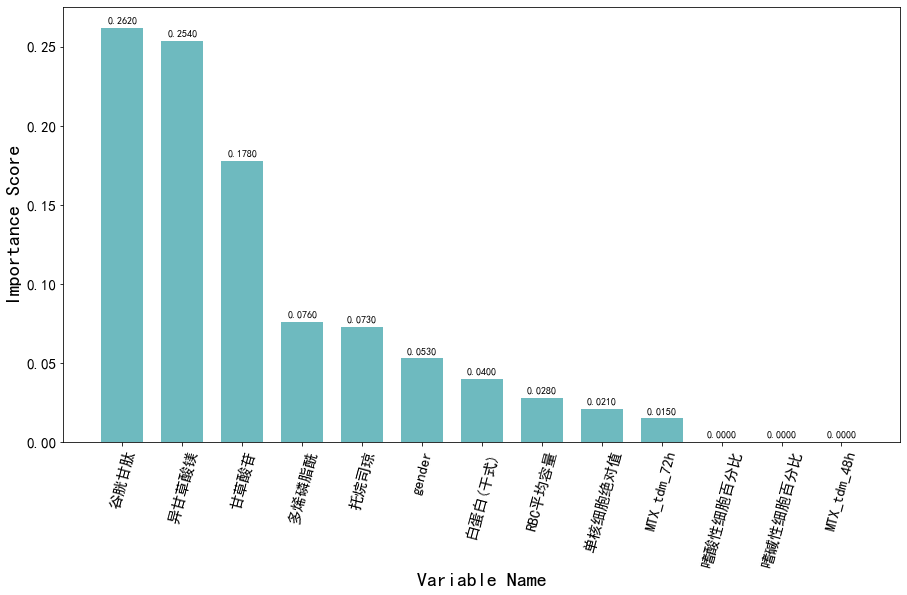

In [1189]:
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']  ##绘图显示中文
mpl.rcParams['axes.unicode_minus'] = False

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rc

names = df_importance['特征']
index = np.arange(len(names))
plt.figure(figsize=(15, 8))
plt.bar(df_importance['特征'], df_importance['重要性评分'], width=0.7,
        color=(0.42941176470588235, 0.7294117647058823, 0.7490196078431373), tick_label=names)
plt.xticks(rotation=75)
# 设置坐标刻度值的大小
plt.tick_params(labelsize=15)

plt.ylabel('Importance Score',fontsize=20)
plt.xlabel('Variable Name',fontsize=20)
for a, b in zip(index, df_importance['重要性评分']):
    plt.text(a, b + 0.002, '%.4f' % b, ha='center', va='bottom', fontsize=10)
# plt.title('重要变量得分柱形图')
# plt.show()

### 散点图

In [51]:
# 判断文件路径是否存在，如果不存在则创建该路径
def mkdir(path):
    folder = os.path.exists(path)
    if not folder:  # 判断是否存在文件夹如果不存在则创建为文件夹
        os.makedirs(path)  # makedirs 创建文件时如果路径不存在会创建这个路径

In [ ]:
# 画图
print('-----------------------画图---------------------------')
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']  ##绘图显示中文
mpl.rcParams['axes.unicode_minus'] = False

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rc
rc('mathtext', default='regular')

# 散点图
# axis设置坐标轴的范围
# plt.axis([-20, 20, 0, 200])
# x为x轴中坐标x的值，y为y轴中坐标y的值，x与y都是长度相同的数组序列，color为点的颜色，marker为散点的形状，
# 折线图刻度调小，要不然点都堆到一块了
ax = plt.gca()
ax.set_xlim(0,10)
ax.set_ylim(0,10)
# plt.scatter(range(len(test_y)),test_y,c='r')
plt.scatter(test_y,predictions,c='b')
# 红色参照线
plt.plot(list(range(test_y.shape[0])), list(range(test_y.shape[0])),color='r')
# plt.plot(list(range(30)), list(range(30)),color='r')
plt.xlabel('Number of Events(unit)')
plt.ylabel('MTX Bone Suppression')

In [52]:
# plt.show()
# 判断图片保存路径是否存在，否则创建
jpg_path = project_path + "/jpg"
mkdir(jpg_path)
plt.savefig(jpg_path + "/他克莫司血药浓度测试集散点图v2.0.jpg", dpi=300)
plt.clf()  # 删除前面所画的图

-----------------------画图---------------------------


<Figure size 432x288 with 0 Axes>

### AUC曲线

In [22]:
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']  ##绘图显示中文
mpl.rcParams['axes.unicode_minus'] = False

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rc

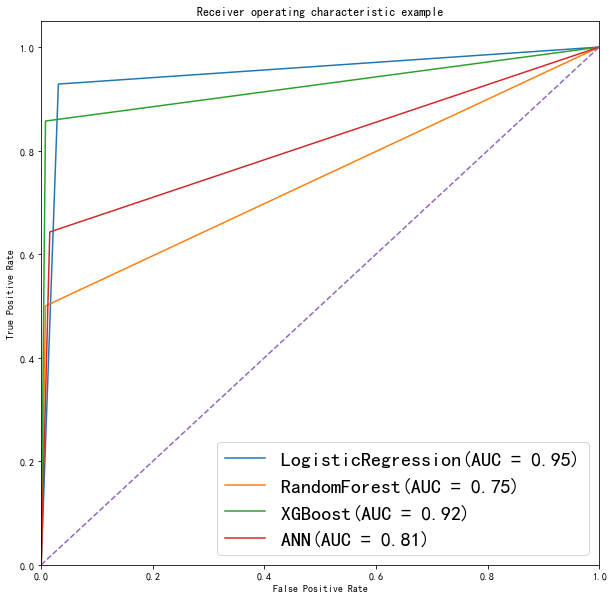

In [36]:
plt.figure(figsize=(10,10))

plt.plot(logistic_fpr, logistic_tpr,label='LogisticRegression(AUC = %0.2f)' % logistic_auc) 
plt.plot(rf_fpr, rf_tpr,label='RandomForest(AUC = %0.2f)' % rf_auc) 
plt.plot(xgb_fpr, xgb_tpr,label='XGBoost(AUC = %0.2f)' % xgb_auc) 
plt.plot(ann_fpr, ann_tpr,label='ANN(AUC = %0.2f)' % ann_auc) 

plt.plot([0, 1], [0, 1],linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC Curve of MTX drug')
plt.legend(loc="lower right", fontsize=20)
plt.show()

### precision曲线

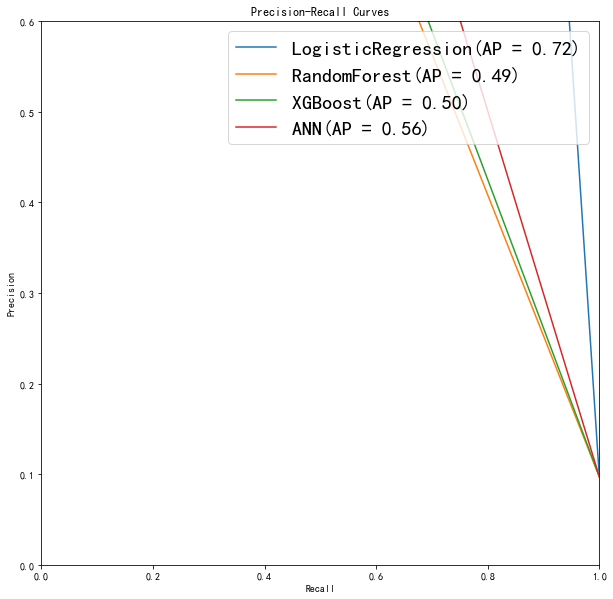

In [57]:
plt.figure(figsize=(10,10))

plt.plot(logistic_recall, logistic_precision, label='LogisticRegression(AP = %0.2f)' % logistic_ap)
plt.plot(rf_recall, rf_precision,label='RandomForest(AP = %0.2f)' % rf_ap) 
plt.plot(xgb_recall, xgb_precision,label='XGBoost(AP = %0.2f)' % xgb_ap) 
plt.plot(ann_recall, ann_precision,label='ANN(AP = %0.2f)' % ann_ap) 
         
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 0.6])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="upper right", fontsize=20)
plt.show()

### SHAP图

In [292]:
?shap.initjs() 

Object `shap.initjs() ` not found.


In [297]:
# SHAP图
from pylab import mpl
from matplotlib import pyplot as plt
mpl.rcParams['font.sans-serif'] = ['SimHei']  ##绘图显示中文
mpl.rcParams['axes.unicode_minus'] = False
from matplotlib import rc
rc('mathtext', default='regular')

import catboost,xgboost
from catboost import *
import shap
shap.initjs()  # notebook环境下，加载用于可视化的JS代码
# xgb_model=xgboost.XGBClassifier(max_depth=5,
#                         learning_rate=0.01,
#                         n_estimators=500,
#                         min_child_weight=0.5,
#                         eta=0.1,
#                         gamma=0.5,
#                         reg_lambda=10,
#                         subsample=0.5,
#                         colsample_bytree=0.8,
#                         nthread=4,
#                         scale_pos_weight=1,
#                         random_state=3)
# xgb_model.fit(tran_x_sm, tran_y_sm)

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(tran_x_sm)  # 传入特征矩阵X，计算SHAP值
# print(shap_values)

Device used : cpu
epoch 0  | loss: 0.75528 | train_auc: 0.63881 |  0:00:00s
epoch 1  | loss: 0.59836 | train_auc: 0.92063 |  0:00:00s
epoch 2  | loss: 0.56821 | train_auc: 0.91119 |  0:00:00s
epoch 3  | loss: 0.50365 | train_auc: 0.96853 |  0:00:00s
epoch 4  | loss: 0.45512 | train_auc: 0.94126 |  0:00:01s
epoch 5  | loss: 0.41852 | train_auc: 0.92727 |  0:00:01s
epoch 6  | loss: 0.43255 | train_auc: 0.94441 |  0:00:01s
epoch 7  | loss: 0.40222 | train_auc: 0.94545 |  0:00:01s
epoch 8  | loss: 0.36702 | train_auc: 0.91993 |  0:00:02s
epoch 9  | loss: 0.35444 | train_auc: 0.96294 |  0:00:02s
epoch 10 | loss: 0.36125 | train_auc: 0.97343 |  0:00:02s
epoch 11 | loss: 0.3187  | train_auc: 0.97203 |  0:00:02s
epoch 12 | loss: 0.28125 | train_auc: 0.97098 |  0:00:03s
epoch 13 | loss: 0.2984  | train_auc: 0.98427 |  0:00:03s
epoch 14 | loss: 0.27376 | train_auc: 0.98147 |  0:00:03s
epoch 15 | loss: 0.23633 | train_auc: 0.97028 |  0:00:03s
epoch 16 | loss: 0.24844 | train_auc: 0.97063 |  0:00:

AssertionError: <class 'pytorch_tabnet.tab_model.TabNetClassifier'> is not currently a supported model type!

In [295]:
# summarize the effects of all the features
shap.summary_plot(shap_values, tran_x_sm, plot_size=(27,20))

Device used : cpu
epoch 0  | loss: 0.75528 | train_auc: 0.63881 |  0:00:00s
epoch 1  | loss: 0.59836 | train_auc: 0.92063 |  0:00:00s
epoch 2  | loss: 0.56821 | train_auc: 0.91119 |  0:00:00s
epoch 3  | loss: 0.50365 | train_auc: 0.96853 |  0:00:00s
epoch 4  | loss: 0.45512 | train_auc: 0.94126 |  0:00:01s
epoch 5  | loss: 0.41852 | train_auc: 0.92727 |  0:00:01s
epoch 6  | loss: 0.43255 | train_auc: 0.94441 |  0:00:01s
epoch 7  | loss: 0.40222 | train_auc: 0.94545 |  0:00:01s
epoch 8  | loss: 0.36702 | train_auc: 0.91993 |  0:00:02s
epoch 9  | loss: 0.35444 | train_auc: 0.96294 |  0:00:02s
epoch 10 | loss: 0.36125 | train_auc: 0.97343 |  0:00:02s
epoch 11 | loss: 0.3187  | train_auc: 0.97203 |  0:00:02s
epoch 12 | loss: 0.28125 | train_auc: 0.97098 |  0:00:03s
epoch 13 | loss: 0.2984  | train_auc: 0.98427 |  0:00:03s
epoch 14 | loss: 0.27376 | train_auc: 0.98147 |  0:00:03s
epoch 15 | loss: 0.23633 | train_auc: 0.97028 |  0:00:03s
epoch 16 | loss: 0.24844 | train_auc: 0.97063 |  0:00:

AssertionError: <class 'pytorch_tabnet.tab_model.TabNetClassifier'> is not currently a supported model type!

In [148]:
# 保存各个变量的shape值的和
df_shap_values=pd.DataFrame(shap_values)
shap_list=[]
shap_pos_list=[]
patient_pos_list=[]
shap_neg_list=[]
patient_neg_list=[]

for j in range(df_shap_values.shape[1]):
    temp=df_shap_values.iloc[:,j]
    df_temp=pd.DataFrame(data={'values':temp})
    # 正shap值
    df_shap_pos=df_temp[df_temp['values']>=0]
    shap_pos_list.append(df_shap_pos.values.sum())
    # 正shap患者数
    patient_pos_list.append(df_shap_pos.shape[0])
    # 负shap值
    df_shap_neg=df_temp[df_temp['values']<0]
    shap_neg_list.append(df_shap_neg.values.sum())
    # 负sahp患者数
    patient_neg_list.append(df_shap_neg.shape[0])
    # shap和
    shap_sum = temp.sum()
    shap_sum = round(shap_sum, 2)
    shap_list.append(shap_sum)

df_shap = pd.DataFrame({'features':list(tran_x.columns),
                        'shap值':shap_list,
                        '正患者数':patient_pos_list,
                       'shap_pos':shap_pos_list,
                        '负患者数':patient_neg_list,
                       'shap_neg':shap_neg_list})
df_shap = df_shap.sort_values(by=['shap值'], ascending=False)
df_shap = df_shap.reset_index(drop=True)

In [149]:
df_shap_values

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,0.493114,0.013439,0.212330,0.161205,-0.017556,0.127539,-0.066257,-0.018847,0.035362,0.023770,...,0.007541,-0.026841,-0.004471,0.007767,-0.002491,-0.011834,0.051021,-0.006103,0.0,0.000336
1,-0.465787,-0.204204,0.057564,-0.128542,0.002040,0.081842,-0.074861,-0.015492,0.023511,-0.013714,...,0.000296,0.020651,-0.007464,0.125231,-0.023509,-0.015810,-0.031778,0.005809,0.0,-0.005455
2,0.333714,-0.009154,0.113778,-0.262280,0.002901,-0.279201,-0.040720,-0.016642,0.002133,-0.016595,...,-0.004984,-0.034450,-0.010802,0.002106,0.001951,-0.010774,-0.032060,-0.010410,0.0,-0.004721
3,0.361266,-0.226927,0.129515,-0.337756,0.004688,0.087664,-0.070344,0.009610,-0.003264,-0.021443,...,0.002200,-0.004920,-0.008501,0.001250,-0.019360,-0.017627,-0.024562,-0.019865,0.0,-0.001508
4,-0.385250,-0.162730,0.044208,-0.098532,0.001598,-0.142825,-0.016146,-0.012490,-0.002583,-0.007621,...,0.005418,-0.022117,-0.001664,-0.017059,-0.026260,-0.013795,0.020640,-0.019700,0.0,-0.004067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569,-0.547174,0.519316,0.064741,0.055347,0.002658,-0.197009,0.254998,-0.011823,-0.007559,-0.006645,...,-0.006296,0.025902,-0.004314,-0.002442,-0.021549,-0.012578,0.015023,-0.013855,0.0,-0.001509
570,-0.383122,-0.161732,0.049291,-0.106437,0.001931,-0.191388,-0.042469,-0.014820,-0.007851,0.014002,...,-0.002495,-0.009965,-0.009123,-0.002402,0.087126,-0.011996,-0.033185,-0.001849,0.0,-0.002297
571,-0.502401,-0.162989,0.058127,0.050063,0.002189,-0.214503,-0.059646,0.030141,0.003770,0.011629,...,-0.002717,-0.030359,0.075569,0.016345,0.083354,-0.010346,0.012017,-0.002183,0.0,-0.001201
572,-0.410083,-0.185747,0.052042,-0.125258,0.002029,0.080268,-0.071100,0.036042,-0.019607,-0.015195,...,-0.004088,0.018902,-0.017878,-0.025403,-0.020374,0.006123,0.017941,-0.017112,0.0,-0.003338


In [150]:
writer = pd.ExcelWriter(project_path + '/data/result/df_27变量_shap值排序.xlsx')
df_shap.to_excel(writer)
writer.save()

### tabnet mask graph

In [299]:
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
TabNet_model = TabNetClassifier()  #TabNetRegressor()
tran_x_x, tran_x_valid, tran_y_y, tran_y_valid = train_test_split(tran_x_sm, tran_y_sm, test_size=0.1, random_state=3)

TabNet_model.fit(X_train=tran_x_x.to_numpy(),  
        y_train=tran_y_y.to_numpy(), 
        eval_set=[(tran_x_valid.to_numpy(), tran_y_valid.to_numpy())], 
        eval_name=['train'], 
        eval_metric=['auc'],
        max_epochs=100,
        patience=15,
        batch_size=128,
        virtual_batch_size=15,
        num_workers=0,
        drop_last=False)

Device used : cpu
epoch 0  | loss: 0.75528 | train_auc: 0.63881 |  0:00:00s
epoch 1  | loss: 0.59836 | train_auc: 0.92063 |  0:00:00s
epoch 2  | loss: 0.56821 | train_auc: 0.91119 |  0:00:00s
epoch 3  | loss: 0.50365 | train_auc: 0.96853 |  0:00:01s
epoch 4  | loss: 0.45512 | train_auc: 0.94126 |  0:00:01s
epoch 5  | loss: 0.41852 | train_auc: 0.92727 |  0:00:01s
epoch 6  | loss: 0.43255 | train_auc: 0.94441 |  0:00:01s
epoch 7  | loss: 0.40222 | train_auc: 0.94545 |  0:00:02s
epoch 8  | loss: 0.36702 | train_auc: 0.91993 |  0:00:02s
epoch 9  | loss: 0.35444 | train_auc: 0.96294 |  0:00:02s
epoch 10 | loss: 0.36125 | train_auc: 0.97343 |  0:00:02s
epoch 11 | loss: 0.3187  | train_auc: 0.97203 |  0:00:02s
epoch 12 | loss: 0.28125 | train_auc: 0.97098 |  0:00:03s
epoch 13 | loss: 0.2984  | train_auc: 0.98427 |  0:00:03s
epoch 14 | loss: 0.27376 | train_auc: 0.98147 |  0:00:03s
epoch 15 | loss: 0.23633 | train_auc: 0.97028 |  0:00:03s
epoch 16 | loss: 0.24844 | train_auc: 0.97063 |  0:00:

In [1190]:
explain_matrix,masks=TabNet_model.explain(tran_x_sm.to_numpy())

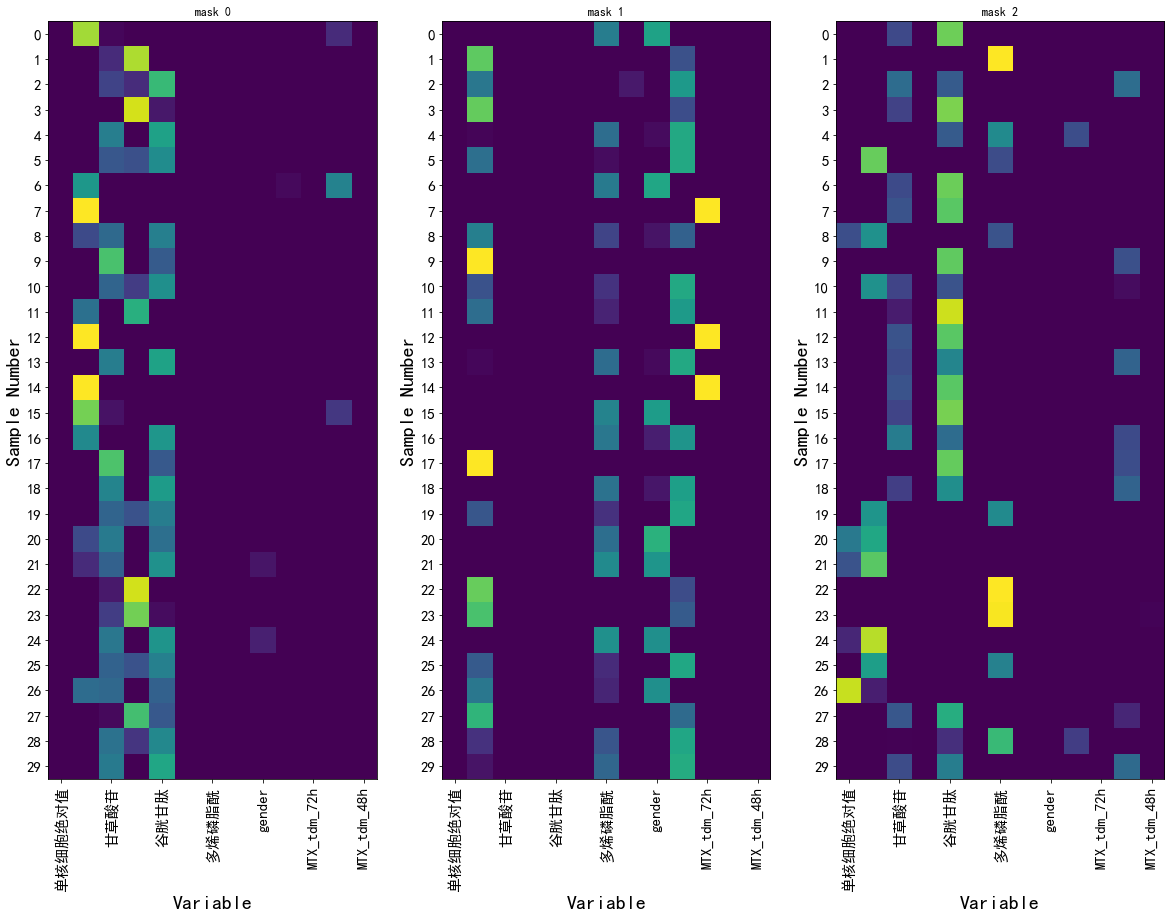

In [1191]:
from matplotlib import pyplot as plt
# fig = plt.figure(figsize=(40,40))
# ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
# plt.yticks(np.arange(0, len(explain_matrix), 1.0))
# plt.xticks(np.arange(0, len(explain_matrix[0]), 1.0))
# ax.set_xticklabels(tran_x_sm.columns, rotation=75)
# plt.ylabel('Sample Number')
# plt.xlabel('Variable')
# # plt.imshow(explain_matrix[:30])  # 显示30个

fig, axs = plt.subplots(1, 3, figsize=(20,20))
for i in range(3):
    axs[i].set_yticks(np.arange(0, len(explain_matrix), 1.0))  # 设置左边间距
    axs[i].set_xticks(np.arange(0, len(explain_matrix[0]), 2.0))
    axs[i].set_ylabel('Sample Number',size=20)
    axs[i].set_xlabel('Variable',size=20)
    # 设置坐标刻度值的大小
    axs[i].tick_params(labelsize=15)
    axs[i].imshow(masks[i][:30])
    axs[i].set_title(f"mask {i}")
    axs[i].set_xticklabels(tran_x_sm.columns[::2], rotation=90)

In [351]:
tran_x_sm.columns

Index(['单核细胞绝对值', '异甘草酸镁', '谷草转氨酶(干式)', '甘草酸苷', '单核细胞百分比', '淋巴细胞百分比',
       '乳酸脱氢酶(干式)', '托烷司琼', '中性细胞绝对值', '嗜酸性细胞绝对值', '谷胱甘肽', '红细胞', '嗜酸性细胞百分比',
       '多烯磷脂酰', '嗜碱性细胞百分比', 'age', 'gender', 'RBC平均容量', 'MTX_tdm_72h',
       '白蛋白(干式)', '中性细胞百分比', 'MTX_tdm_48h', '总蛋白(干式)', '淋巴细胞绝对值', '吸烟史',
       '肌酐(干式)', 'MTX_tdm_24h', '日剂量', '长春新碱', 'RBC血红浓度'],
      dtype='object')